In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

In [2]:
pd.set_option('display.max_columns', None) 
pd.set_option('display.max_rows', None)
np.set_printoptions(threshold = np.inf)

### 1) Loading data

In [3]:
train_data_path = os.getcwd() + "/data/google_stock_price_Train.csv"

In [4]:
raw_data_train = pd.read_csv(train_data_path)
data_train = raw_data_train.iloc[:,1:2].values #dataframe values to numpy array
data_train
print(data_train.shape)

(1258, 1)


### 2) Feature Scaling using Normalization

In [5]:
from sklearn.preprocessing import MinMaxScaler

In [6]:
sc = MinMaxScaler(feature_range=(0, 1))# create an object of class MinMaxScaler

sc.fit(data_train)
print("max of observed values:", sc.data_max_[0])
print("min of observed values:", sc.data_min_[0])


max of observed values: 816.68
min of observed values: 279.12


In [7]:
data_train_scaled = sc.fit_transform(data_train)

In [8]:
data_train_scaled[:6]

array([[0.08581368],
       [0.09701243],
       [0.09433366],
       [0.09156187],
       [0.07984225],
       [0.0643277 ]])

### 3) Data structure with 60 timesteps and 1 output

#### i. RNN learns from the 60 previous stock price timesteps to find the patterns / trends and based on it's understanding, rnn predicts to predict the next output i.e stock price at time t+1

In [9]:
X_train = [] # 60 previous stock prices for each observation for each financial day
y_train = [] # next stock price

In [10]:
for i in range(60, 1258):
    X_train.append(data_train_scaled[i-60:i,0])
    y_train.append(data_train_scaled[i,0])
    
X_train, y_train = np.array(X_train), np.array(y_train)

In [11]:
print("Training data", X_train[:3])
print("Test data", y_train[:3])
print(X_train.shape)
print(y_train.shape)

Training data [[0.08581368 0.09701243 0.09433366 0.09156187 0.07984225 0.0643277
  0.0585423  0.06568569 0.06109085 0.06639259 0.0614257  0.07474514
  0.02797827 0.02379269 0.02409033 0.0159238  0.01078949 0.00967334
  0.01642607 0.02100231 0.02280676 0.02273235 0.02810849 0.03212665
  0.0433812  0.04475779 0.04790163 0.0440695  0.04648783 0.04745517
  0.04873875 0.03936305 0.04137213 0.04034898 0.04784582 0.04325099
  0.04356723 0.04286033 0.04602277 0.05398467 0.05738894 0.05714711
  0.05569611 0.04421832 0.04514845 0.04605997 0.04412531 0.03675869
  0.04486941 0.05065481 0.05214302 0.05612397 0.05818885 0.06540665
  0.06882953 0.07243843 0.07993526 0.07846566 0.08034452 0.08497656]
 [0.09701243 0.09433366 0.09156187 0.07984225 0.0643277  0.0585423
  0.06568569 0.06109085 0.06639259 0.0614257  0.07474514 0.02797827
  0.02379269 0.02409033 0.0159238  0.01078949 0.00967334 0.01642607
  0.02100231 0.02280676 0.02273235 0.02810849 0.03212665 0.0433812
  0.04475779 0.04790163 0.0440695  0

In [13]:
# 2D to 3D vector ==> (no of entries, no of timesteps, no of indicators/predictors)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1)) 
print(X_train.shape)

(1198, 60, 1)


### 4) Building the RNN - LSTM to predict continuous value

In [14]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

2024-01-28 02:02:44.404133: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


#### Initializing the RNN

In [15]:
regressor = Sequential() 

2024-01-28 02:03:13.281076: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


#### Adding LSTM layers and dropout

In [16]:
# 3D data for LSTM input layer, return_sequences=True as I will be adding more LSTM layer in model
# 1st LSTM layer
regressor.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
regressor.add(Dropout(.2))

# 2nd LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(.2))

# 3rd LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(.2))

# 4th LSTM layer
regressor.add(LSTM(units=50, return_sequences=False))
regressor.add(Dropout(.2))

#### Adding output layer
##### Since output is only a single dimension (predicting a stock price at t+1), unit = 1 in output layer

In [17]:
regressor.add(Dense(units=1))

#### Compiling LSTM architecture

In [18]:
regressor.compile(optimizer="adam", loss="mean_squared_error")

In [19]:
regressor.fit(X_train, y_train, epochs=100, batch_size=32)

Epoch 1/100
38/38 [==============================] - 9s 100ms/step - loss: 0.0427
Epoch 2/100
38/38 [==============================] - 4s 94ms/step - loss: 0.0076
Epoch 3/100
38/38 [==============================] - 3s 88ms/step - loss: 0.0072
Epoch 4/100
38/38 [==============================] - 3s 91ms/step - loss: 0.0063
Epoch 5/100
38/38 [==============================] - 4s 102ms/step - loss: 0.0062
Epoch 6/100
38/38 [==============================] - 3s 88ms/step - loss: 0.0053
Epoch 7/100
38/38 [==============================] - 3s 84ms/step - loss: 0.0047
Epoch 8/100
38/38 [==============================] - 3s 84ms/step - loss: 0.0047
Epoch 9/100
38/38 [==============================] - 3s 90ms/step - loss: 0.0047
Epoch 10/100
38/38 [==============================] - 4s 98ms/step - loss: 0.0051
Epoch 11/100
38/38 [==============================] - 3s 92ms/step - loss: 0.0045
Epoch 12/100
38/38 [==============================] - 3s 91ms/step - loss: 0.0044
Epoch 13/100
38/38 [===

### 5) Predicting stock prices

#### Importing real stock prices of 2017

In [20]:
path_test = os.getcwd() + "/data/google_stock_price_Test.csv"

In [21]:
raw_data_test = pd.read_csv(path_test)
data_test = raw_data_test.iloc[:,1:2].values #dataframe values to numpy array
data_test
print(data_test.shape)

(20, 1)


In [22]:
data_total = pd.concat((raw_data_train["Open"], raw_data_test["Open"]), axis=0)
data_total.shape

(1278,)

In [23]:
inputs = data_total[(len(data_total) - len(raw_data_test) - 60):].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)

/var/folders/tt/q4hqdtbs24gdc3d6ts_l8_3w0000gn/T/ipykernel_18347/3009435234.py:1: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  inputs = data_total[(len(data_total) - len(raw_data_test) - 60):].values


#### For each observation of Jan 2017 stock price, I have 60 previous stock prices that are needed to predict the next stock price

In [24]:
X_test = [] 
for i in range(60, 80): # test data has only 20 financial days i.e 60+20
    X_test.append(inputs[i-60:i,0])
    
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1)) # converting to the 3D vector
# print(X_test.shape)

predicted_data_test = regressor.predict(X_test)
predicted_data_test = sc.inverse_transform(predicted_data_test)

1/1 [==============================] - 2s 2s/step


In [25]:
predicted_data_test

array([[780.4749 ],
       [777.9171 ],
       [777.4304 ],
       [778.222  ],
       [780.9316 ],
       [786.1014 ],
       [791.5133 ],
       [794.6236 ],
       [795.751  ],
       [795.7815 ],
       [795.4088 ],
       [794.90735],
       [794.5032 ],
       [794.7463 ],
       [795.52545],
       [799.28796],
       [805.4826 ],
       [812.7293 ],
       [817.67053],
       [815.7987 ]], dtype=float32)

### 6) Visualizing the results

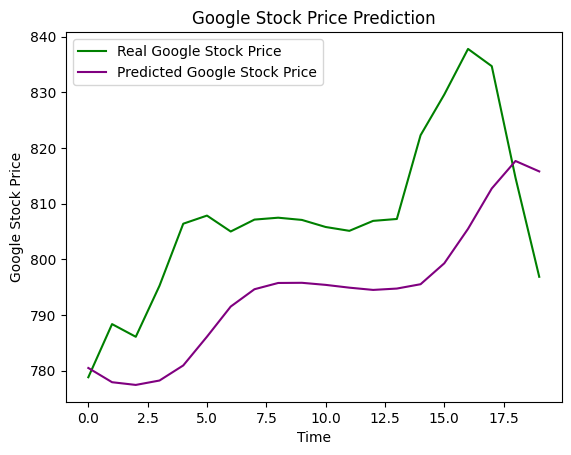

In [26]:
plt.plot(data_test, color = 'Green', label = 'Real Google Stock Price')
plt.plot(predicted_data_test, color = 'Purple', label = 'Predicted Google Stock Price')
plt.title('Google Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Google Stock Price')
plt.legend()
plt.show()